In [1]:
import pandas as pd
import ast
import math
import os
import re
import matplotlib.pyplot as plt
from collections import Counter
import glob

In [2]:

def split_csv(input_file, output_folder="BerTagHanZeitung", output_prefix="split", parts=10):
    # Read CSV
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    df = pd.read_csv(input_file)

    # Number of rows per chunk
    chunk_size = math.ceil(len(df) / parts)

    for i in range(parts):
        start = i * chunk_size
        end = start + chunk_size
        chunk = df.iloc[start:end]

        if not chunk.empty:
            output_file = os.path.join(output_folder, f"{output_prefix}_{i+1}.csv")
            chunk.to_csv(output_file, index=False)
            print(f"Created: {output_file} ({len(chunk)} rows)")

# # Example usage
# split_csv("./BerTagHanZeitung/ids_split_5_Bakhadir.csv", output_prefix="ids_split_5_Bakhadir", parts=4)

In [ ]:
def compare_ids(file1, file2):
    # Read the files
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    ids1 = set(df1["item_id"])
    ids2 = set(df2["item_id"])

    # Compare
    only_in_file1 = ids1 - ids2
    only_in_file2 = ids2 - ids1
    common = ids1 & ids2

    print(f"Total in {file1}: {len(ids1)}")
    print(f"Total in {file2}: {len(ids2)}")
    print(f"Common IDs: {len(common)}")
    print(f"Only in {file1}: {len(only_in_file1)}")
    print(f"Only in {file2}: {len(only_in_file2)}")

    return only_in_file1, only_in_file2, common
# only_in_1, only_in_2, common_ids = compare_ids("./outputdata/dataset_2764651-8_0_0_623.csv", "./outputdata/dataset_2764651-8_1_0_758.csv")

In [4]:
def check_duplicates(file_name):
    df = pd.read_csv(file_name)

    # Find duplicate IDs
    duplicates = df[df.duplicated("id", keep=False)]

    if duplicates.empty:
        print(f"✅ {os.path.basename(file_name)}: No duplicates found.")
    else:
        print(f"⚠️ {os.path.basename(file_name)}: Found {duplicates.shape[0]} duplicate rows:")
        print(duplicates)

    return duplicates



In [5]:
def check_duplicates_in_folder(folder_path: str):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        try:
            check_duplicates(file_path)
        except Exception as e:
            print(f"⚠️ Could not check {file}: {e}")

In [10]:
def count_unique_ids_in_folder(folder_path: str):
    unique_ids = set()
    csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        try:
            df = pd.read_csv(file_path, usecols=["item_id"])  # only read the id column
            unique_ids.update(df["item_id"].dropna().astype(str))
        except Exception as e:
            print(f"⚠️ Could not read {file}: {e}")

    print(f"📊 Total distinct IDs across all CSVs: {len(unique_ids)}")
    return unique_ids

In [13]:
check_duplicates_in_folder("./BerTagHanZeitung")

✅ ids_split_0_Farrukh.csv: No duplicates found.
✅ ids_split_10_Kozmin_1.csv: No duplicates found.
✅ ids_split_10_Kozmin_2.csv: No duplicates found.
✅ ids_split_10_Kozmin_3.csv: No duplicates found.
✅ ids_split_10_Kozmin_4.csv: No duplicates found.
✅ ids_split_1_Jakhongir_1.csv: No duplicates found.
✅ ids_split_1_Jakhongir_2.csv: No duplicates found.
✅ ids_split_1_Jakhongir_3.csv: No duplicates found.
✅ ids_split_1_Jakhongir_4.csv: No duplicates found.
✅ ids_split_2_Murod_1.csv: No duplicates found.
✅ ids_split_2_Murod_2.csv: No duplicates found.
✅ ids_split_2_Murod_3.csv: No duplicates found.
✅ ids_split_2_Murod_4.csv: No duplicates found.
✅ ids_split_3_Mahdi_1.csv: No duplicates found.
✅ ids_split_3_Mahdi_2.csv: No duplicates found.
✅ ids_split_3_Mahdi_3.csv: No duplicates found.
✅ ids_split_3_Mahdi_4.csv: No duplicates found.
✅ ids_split_4_Bakhadir_1.csv: No duplicates found.
✅ ids_split_4_Bakhadir_2.csv: No duplicates found.
✅ ids_split_4_Bakhadir_3.csv: No duplicates found.
✅ ids_s

In [60]:
"""" Count unique IDs across all CSV files in a folder. So we can see if there are overlaps and also get the total number of newspapers issued. """
unique_ids = count_unique_ids_in_folder("./BerTagHanZeitung/outdata")
newspaper_issues_count = len(unique_ids)

📊 Total distinct IDs across all CSVs: 30899


In [12]:
def remove_failed_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove rows where the column 'success' is False.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with a 'success' column.

    Returns
    -------
    pd.DataFrame
        Cleaned DataFrame without rows where success == False.
    """
    if "success" not in df.columns:
        raise ValueError("DataFrame must contain a 'success' column")

    return df[df["success"] != False].reset_index(drop=True)

In [13]:
def select_term_dataset(df, term):
    """
    Create a new dataset with only the metadata columns + one chosen term column.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataset containing all columns.
    term : str
        One of the terms: 'anarch', 'terror', 'kommun', 'sozial', 'revolut'.
    
    Returns:
    --------
    pd.DataFrame
        A new DataFrame with the selected columns.
    """
    valid_terms = ["anarch", "terror", "kommunis", "sozial", "revolut"]
    if term not in valid_terms:
        raise ValueError(f"Invalid term '{term}'. Choose one of {valid_terms}.")
    
    cols = ["item_id", "publisher", "title", "pub_date", "page_num", "chunk", term]
    return df[cols].copy()

In [14]:
def to_list(val):
    """
    Convert string representations of lists into real lists.
    If input is already a list, return it unchanged.
    If parsing fails, returns an empty list.
    """
    if isinstance(val, list):  # already a list
        return val
    if val is None or (isinstance(val, str) and val.strip() == ""):
        return []
    try:
        return ast.literal_eval(val)  # safely evaluate list string
    except Exception:
        return []

In [15]:
def filter_non_empty_lists(df, col):
    """
    Remove rows where the list is empty.
    Modifies the DataFrame in place by filtering rows.
    """
    df.drop(df[df[col].apply(lambda x: len(x) == 0)].index, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [16]:
def remove_short_words(df, col, min_len=5):
    """
    Remove words shorter than min_len from lists in the given column.
    Modifies the DataFrame in place.
    """
    df[col] = df[col].apply(lambda lst: [w for w in lst if len(w.strip()) >= min_len])

In [17]:
def collect_unique_words(df, col):
    """
    Create a set of all unique words from the lists in the given column.
    """
    all_words = set()
    for lst in df[col]:
        all_words.update(lst)
    return all_words

In [18]:

def clean_non_alpha(df, col="original_lists"):
    """
    Remove all non-alphabetic characters from words,
    but keep spaces and hyphens.
    Supports German letters ä, ö, ü, Ä, Ö, Ü, ß.
    Modifies the DataFrame in place.
    """
    pattern = re.compile(r"[^a-zA-ZäöüÄÖÜß\s\-]")  # keep letters, space, hyphen
    df[col] = df[col].apply(lambda lst: [pattern.sub("", w) for w in lst])

In [19]:
def to_lowercase(df, col="original_lists"):
    """
    Convert all words in the lists of the given column to lowercase.
    Modifies the DataFrame in place.
    """
    df[col] = df[col].apply(lambda lst: [w.lower() for w in lst])

Collect all data from the dataset files in "BerTagHanZeitung" folder

In [20]:
def load_and_combine_csvs(folder_path, output_path=None):
    """
    Load all CSV files from a folder and combine them into one DataFrame.
    Optionally save the combined dataset to output_path.
    """
    # Find all CSV files in the folder
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    
    if not all_files:
        print("No CSV files found in folder.")
        return pd.DataFrame()
    
    # Read and concatenate
    df_list = []
    for file in all_files:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except Exception as e:
            print(f"Skipping {file} due to error: {e}")
    
    combined_df = pd.concat(df_list, ignore_index=True)
    
    # Optionally save
    if output_path:
        combined_df.to_csv(output_path, index=False)
        print(f"Combined CSV saved to {output_path}")
    
    return combined_df

In [22]:
# Merge all CSV files in the folder
big_df = load_and_combine_csvs("./BerTagHanZeitung/outdata", output_path="./BerTagHanZeitung/outdata/combined_dataset.csv")

print(len(big_df))


C:\Users\abduk\AppData\Local\Temp\ipykernel_4716\598742795.py:17: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Combined CSV saved to ./BerTagHanZeitung/outdata/combined_dataset.csv
12775644


In [68]:
def words_per_date(df, date_col="pub_date", text_col="chunk"):
    """
    Group by date and count total number of words in `text_col`.

    Parameters
    ----------
    df : DataFrame
        Dataset with publication dates and text chunks.
    date_col : str, default "pub_date"
        Column containing publication dates.
    text_col : str, default "chunk"
        Column containing text strings to count words from.

    Returns
    -------
    DataFrame with columns: [date_col, "word_count"]
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce").dt.date
    
    # Count words in each chunk
    df["word_count"] = df[text_col].astype(str).str.split().str.len()
    
    # Aggregate by date
    result = df.groupby(date_col)["word_count"].sum().reset_index()
    return result


def issues_per_date(df, date_col="pub_date", id_col="item_id"):
    """
    Group by date and count distinct newspaper issues.

    Parameters
    ----------
    df : DataFrame
        Dataset with publication dates and issue IDs.
    date_col : str, default "pub_date"
        Column containing publication dates.
    id_col : str, default "item_id"
        Column containing newspaper issue IDs.

    Returns
    -------
    DataFrame with columns: [date_col, "issue_count"]
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce").dt.date
    
    result = df.groupby(date_col)[id_col].nunique().reset_index(name="issue_count")
    return result

In [69]:
# Words per date
word_stats = words_per_date(big_df)
print(word_stats.head())

# Issues per date
issue_stats = issues_per_date(big_df)
print(issue_stats.head())

     pub_date  word_count
0  1878-01-04         300
1  1878-01-05        1400
2  1878-01-06         700
3  1878-01-08         700
4  1878-01-09         700
     pub_date  issue_count
0  1878-01-04            1
1  1878-01-05            1
2  1878-01-06            1
3  1878-01-08            1
4  1878-01-09            1


In [23]:
import pandas as pd
import re

def count_words_in_column(df: pd.DataFrame, col: str) -> int:
    """
    Count the total number of words in a given column of string values.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset.
    col : str
        The name of the column containing text strings.

    Returns
    -------
    int
        The total number of words across all rows in the column.
    """
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame")

    # Use regex to split on non-alphabetic characters
    total_words = df[col].dropna().apply(
        lambda x: len(re.findall(r"\b\w+\b", str(x)))
    ).sum()

    return total_words

In [24]:
total_words = count_words_in_column(big_df, "chunk")

In [25]:
print(total_words)

1328148049


In [26]:
big_df = remove_failed_rows(big_df)
print(len(big_df))

299347


In [28]:
print(big_df.columns)

Index(['item_id', 'publisher', 'title', 'pub_date', 'page_num', 'chunk',
       'success', 'anarch', 'terror', 'kommunis', 'sozial', 'revolut'],
      dtype='object')


1) convert the string values of the 'term' column to lists

2) remove all non-alphabetic characters except spaces in the strings inside lists

3) convert to lowercase

4) maybe remove all strings with length < 5 in the list ?

5) remove empty lists

6) see if the size of the set has changed

7) get the set of matched words of one term's lists
8) If the next letter after space is capital, then most likely the match is unwanted

In [29]:

terms = ["anarch", "terror", "kommunis", "sozial", "revolut"]
sub_dfs = {}
for term in terms:
    sub_dfs[term] = select_term_dataset(big_df, term)

In [30]:
for term, df in sub_dfs.items():
    print(f"{term}: {len(df)} rows")

anarch: 299347 rows
terror: 299347 rows
kommunis: 299347 rows
sozial: 299347 rows
revolut: 299347 rows


In [ ]:
""" clean each sub-dataset """
for term, df in sub_dfs.items():
    df[term] = df[term].apply(lambda lst: to_list(lst))
    clean_non_alpha(df, term)
    to_lowercase(df, term)
    remove_short_words(df, term, min_len=4)
    filter_non_empty_lists(df, term)
    print(f"{term}: {len(df)} rows after cleaning")



anarch: 19072 rows after cleaning
terror: 6362 rows after cleaning
kommunis: 20477 rows after cleaning
sozial: 229818 rows after cleaning
revolut: 42020 rows after cleaning


In [ ]:
"""Filter terror sub-dataset to remove two-word matches where the first word ends with 'ter'."""
def filter_list(lst):
    filtered = []
    for w in lst:
        words = w.strip().split()
        if len(words) == 2 and words[0].endswith("ter"):
            # skip this match
            continue
        filtered.append(w)
    return filtered

sub_dfs["terror"]["terror"] = sub_dfs["terror"]["terror"].apply(filter_list)


In [38]:
"""Filter anarch sub-dataset to remove words that don't have obvious anarchist roots."""
def build_confusion_pattern(term, single_confusions, multi_confusions):
    """Build an OCR-tolerant regex for a given term."""
    # Escape first
    term = re.escape(term)

    # Apply multi-character confusions
    for seq, repl in multi_confusions.items():
        term = re.sub(seq, repl, term, flags=re.IGNORECASE)

    # Apply single-character confusions
    pattern_chars = []
    for char in term:
        if char.lower() in single_confusions:
            pattern_chars.append(single_confusions[char.lower()])
        else:
            pattern_chars.append(char)

    return "".join(pattern_chars)


def filter_anarch_words(df, col="anarch"):
    """
    Keep only words with obvious anarchist roots.
    Allowed roots: anarchi*, anarcho*, with OCR confusions.
    """
    # Your confusion dictionaries
    single_confusions = { 
        "a": "[aä]", "ä": "[äa]", "b": "[b]", "c": "[cce]", "d": "[do]", 
        "e": "[eéc]", "f": "[fſ]", "g": "[gq]", "h": "[hn]", "i": "[i1ltn]", 
        "j": "[j]", "k": "[kck]", "l": "[lt1i]", "m": "[mnnrn]", "n": "[nhu]", 
        "o": "[o0]", "p": "[p]", "q": "[qg]", "r": "[r]", "s": "[sſf]", 
        "ß": "[ßssſ]", "t": "[t1i]", "u": "[uüvn]", "ü": "[üu]", "v": "[vu]", 
        "w": "[wvv]", "x": "[x]", "y": "[y]", "z": "[z2]",
    }
    multi_confusions = { 
        "rn": "(?:rn|m)", "vv": "(?:vv|w)", "ri": "(?:ri|n)", "cl": "(?:cl|d)", 
        "ch": "(?:ch|h|c|n)", "ck": "(?:ck|k)", "ſt": "(?:ſt|st|f)", 
        "ni": "(?:ni|m)", "li": "(?:li|h)", "tt": "(?:tt|n)",
    }

    # Build regex for anarchi* and anarcho*
    anarchi_pat = build_confusion_pattern("anarchi", single_confusions, multi_confusions)
    anarcho_pat = build_confusion_pattern("anarcho", single_confusions, multi_confusions)

    regex = re.compile(f"({anarchi_pat}|{anarcho_pat})", re.IGNORECASE)

    # Filter function
    def keep_anarch(words):
        return [w for w in words if regex.search(w)]

    cleaned_df = df.copy()
    cleaned_df[col] = cleaned_df[col].apply(keep_anarch)
    return cleaned_df

sub_dfs["anarch"] = filter_anarch_words(sub_dfs["anarch"], col="anarch")

In [39]:
unique_words_sets = {}
for term, df in sub_dfs.items():
    unique_words = collect_unique_words(df, term)
    unique_words_sets[term] = unique_words
    print(f"{term}: {len(unique_words_sets[term])} unique words")
    print(unique_words_sets[term])

anarch: 1538 unique words
{' anarchislen ', ' anarchistengeseh', ' anarchislengruppe ', ' anarchislenfnicht', ' anarcho', ' salonanarchisten ', '- anarchiftentonferenz ', ' anarchtflenkonferenz ', ' banarnndflüif', ' anarchistenblätter ', ' edelanarchisinns ', ' anarchististhe ', ' anarchismiis ', ' anarchislische ', ' romanarnin ', ' auarchiftisch-', ' auarchisteuveriue ', ' sittlichkeilsanarchie', ' anarchislnche ', ' anarchismns', ' anarchistcngcfctz', ' anarchistengesetz ', ' frauarnomu', ' anarchi- ', ' niikanarcichez ', ' anarchistenart ', ' anarchistenriecher ', ' anarciizcnd', ' maharciüclib ', ' kaharcttbetr', ' aharnintc', ' anarchisteit ', ' lgauarclle', ' jedanarhtal', ' anarchistenkonserenz ', ' auarchiste', ' anarchistenblatt', ' anarchistcmliigeziese', ' hauarhlld', ' anarchistischenrichtu', ' anarchistenelement ', '-anarchisteit ', ' frauärcichs ', ' anarchistensührers ', ' granarhl', ' anarchistenattentat', ' ressortanarchie', ' anarchiften- ', 'auarchisiische ', ' ana

In [41]:
# regex to remove all non-alphabetic chars, but keep äöüß and their uppercase forms
cleaning = re.compile(r"[^a-zA-ZäöüÄÖÜß]")

# create a new column with cleaned lists
sub_dfs["kommunis"]["kommunis_clean"] = sub_dfs["kommunis"]["kommunis"].apply(
    lambda lst: [cleaning.sub("", w) for w in lst]
)
print(len(sub_dfs["kommunis"]))

20477


In [42]:
# List of unwanted substrings
unwanted_substrings = [
    "kommuna", "kommnna", "kommuua", "kommune", "kommnne", "kommuue",
    "communa", "commnna", "commuua", "commune", "commuue", "commnne", "komme"
]

# Filter function
def filter_unwanted(words, unwanted):
    return [w for w in words if not any(u in w.lower() for u in unwanted)]

# Apply to your dataset
sub_dfs["kommunis"]["kommunis_filtered"] = sub_dfs["kommunis"]["kommunis_clean"].apply(
    lambda lst: filter_unwanted(lst, unwanted_substrings)
)
print(len(sub_dfs["kommunis"]))

20477


In [43]:
filter_non_empty_lists(sub_dfs["kommunis"], "kommunis_filtered")
print(len(sub_dfs["kommunis"]))

20477


In [44]:
""" clean each sub-dataset """
for term, df in sub_dfs.items():
    clean_non_alpha(df, term)
    to_lowercase(df, term)
    remove_short_words(df, term, min_len=4)
    filter_non_empty_lists(df, term)
    print(f"{term}: {len(df)} rows after cleaning")

anarch: 14485 rows after cleaning
terror: 6232 rows after cleaning
kommunis: 20477 rows after cleaning
sozial: 229818 rows after cleaning
revolut: 42020 rows after cleaning


1) Graph showing the frequency of matches by date
2) Graph showing the the top 5 words that were present in the chunks where the match was found

In [45]:
def plot_frequency_by_date(df, col, date_col="pub_date"):
    """
    Plot frequency of matches per year.
    Works with full dates like YYYY-MM-DD.
    """
    # Ensure pub_date is datetime
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # Count rows with non-empty matches per year
    freq = df.groupby(df[date_col].dt.year)[col].apply(lambda x: sum(len(lst) > 0 for lst in x))
    freq = freq.dropna().sort_index()

    plt.figure(figsize=(10, 5))
    plt.plot(freq.index, freq.values, marker="o")
    plt.title(f"Frequency of '{col}' matches by year")
    plt.xlabel("Year")
    plt.ylabel("Number of Matches")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

Plotting frequency for term: anarch


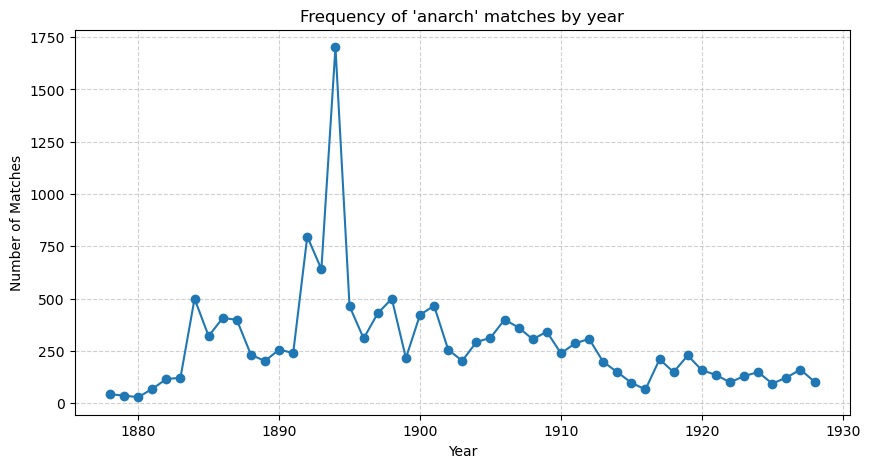

Plotting frequency for term: terror


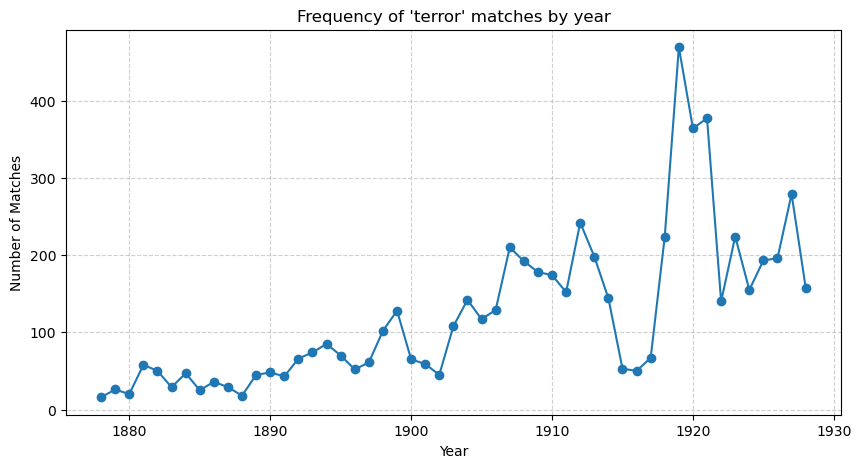

Plotting frequency for term: kommunis


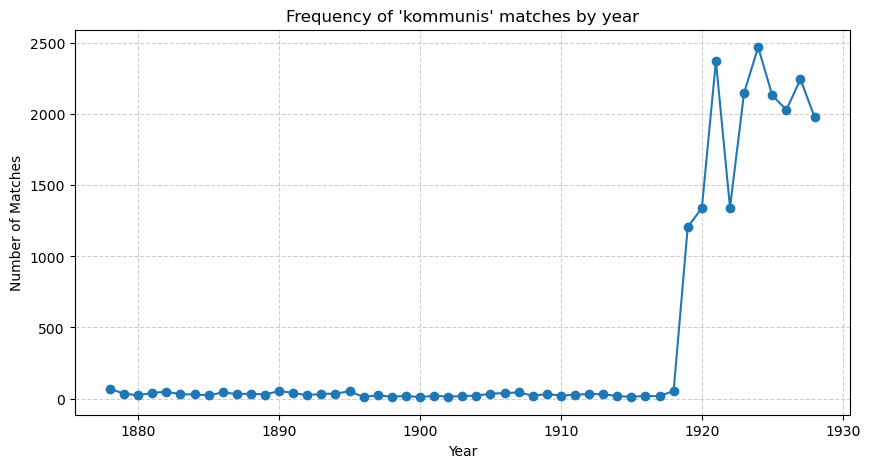

Plotting frequency for term: sozial


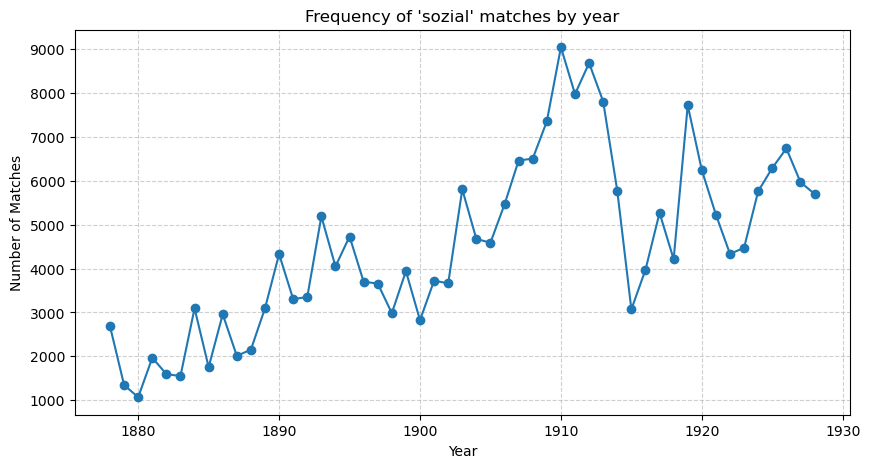

Plotting frequency for term: revolut


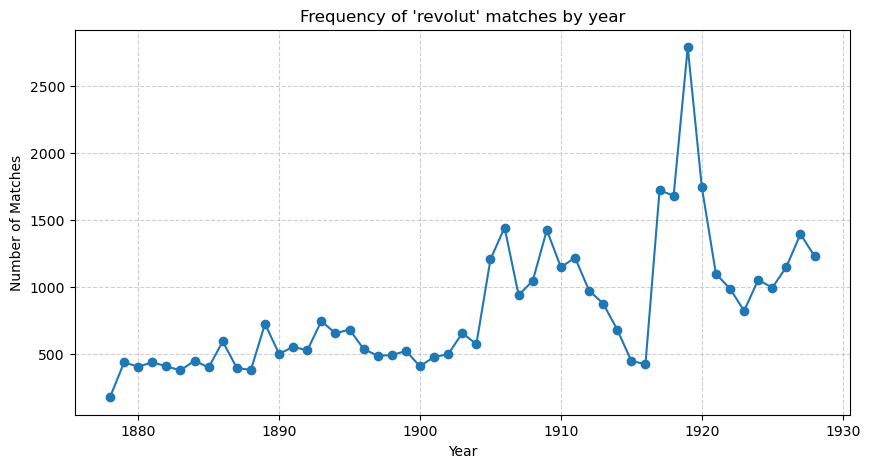

In [46]:
for term, df in sub_dfs.items():
    print(f"Plotting frequency for term: {term}")
    plot_frequency_by_date(df, col=term, date_col="pub_date")

In [53]:
def plot_top_words_in_chunks(
    df, col, chunk_col="chunk", top_n=5, min_len=4, exclude_words=None
):
    """
    Plot the top N context words from chunks where matches were found.
    Excludes:
      - German stopwords
      - Words shorter than min_len
      - Custom exclude_words (e.g., unique_words_sets[col])
    """
    # Extended German stopwords (basic + common short words)
    GERMAN_STOPWORDS = {
        "alle", "allein", "als", "aber", "auch", "am", "an", "anderer", "anderen", "anderes",
        "andere", "da", "daß", "der", "den", "denn", "des", "dies", "dieser", "dieses", "diese",
        "durch", "du", "dich", "einer", "einem", "einen", "etwas", "er", "es", "für", "gegen",
        "hab", "hat", "hatte", "haben", "habe", "hast", "hatten", "hier", "ihr", "ihre", "ihrer",
        "ihres", "ihn", "ihm", "ich", "im", "in", "immer", "kann", "können", "könnte", "man",
        "manche", "mancher", "manches", "mehr", "mein", "meine", "meiner", "meines", "meinen",
        "mich", "muss", "müssen", "nach", "noch", "nicht", "nun", "nur", "oder", "ohne", "sie",
        "sein", "seine", "seiner", "seines", "seinen", "selbst", "solche", "solcher", "solches",
        "so", "soll", "sollen", "sollte", "von", "vor", "wer", "was", "wessen", "wem", "wen",
        "wo", "wenn", "wie", "war", "wird", "werden", "wurde", "will", "wollen", "jetzt", "viel",
        "viele", "euch", "unser", "unsere", "unserer", "unseres", "unseren", "euer", "eure",
        "eurer", "eures", "euren", "won", "warum", "wieso", "weshalb", "sich", "eine", "über", 
        "sind", "unter", "worden", "sehr", "dass", "dann", "welche", "würde", "doch", "schon",
        "diesem", "weil", "werde", "eines"
    }
    if df.empty:
        print(f"The dataset is empty. No matches to plot for '{col}'.")
        return

    all_text = " ".join(df[chunk_col].astype(str))

    # Tokenize: keep letters (including German letters) and hyphens
    tokens = re.findall(r"[a-zA-ZäöüÄÖÜß\-]+", all_text.lower())

    # Build stopword set
    STOPWORDS = set(GERMAN_STOPWORDS)
    if exclude_words is not None:
        STOPWORDS = STOPWORDS.union(w.lower() for w in exclude_words)

    # Filter tokens
    tokens = [w for w in tokens if w not in STOPWORDS and len(w) >= min_len]

    if not tokens:
        print("No words left after filtering stopwords and exclusions.")
        return

    # Count and plot
    counter = Counter(tokens)
    top_words = counter.most_common(top_n)

    words, counts = zip(*top_words)

    plt.figure(figsize=(15, 5))
    plt.bar(words, counts, color="skyblue")
    plt.title(f"Top {top_n} context words in chunks with '{col}' matches")
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.show()

Plotting top words for term: anarch


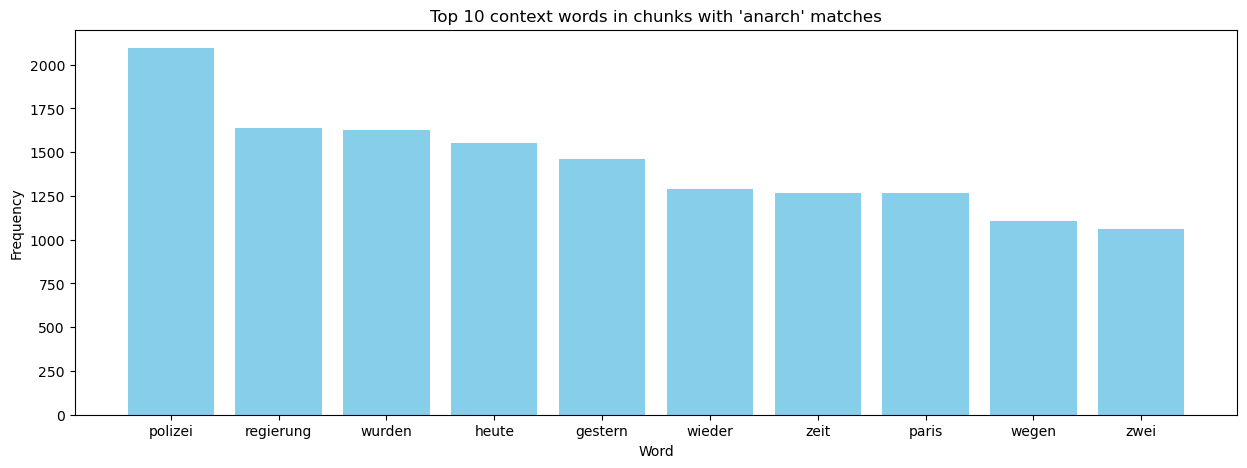

Plotting top words for term: terror


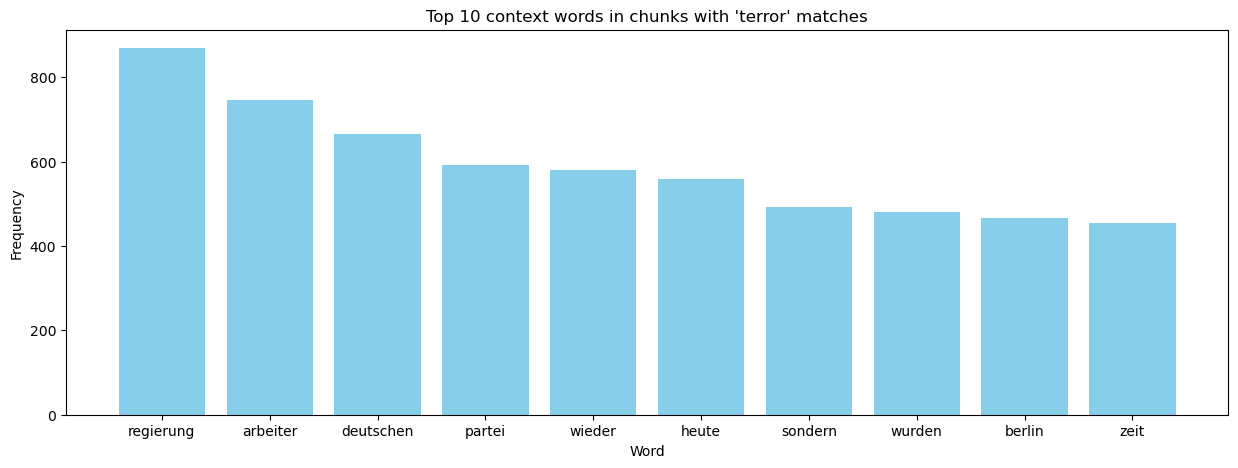

Plotting top words for term: kommunis


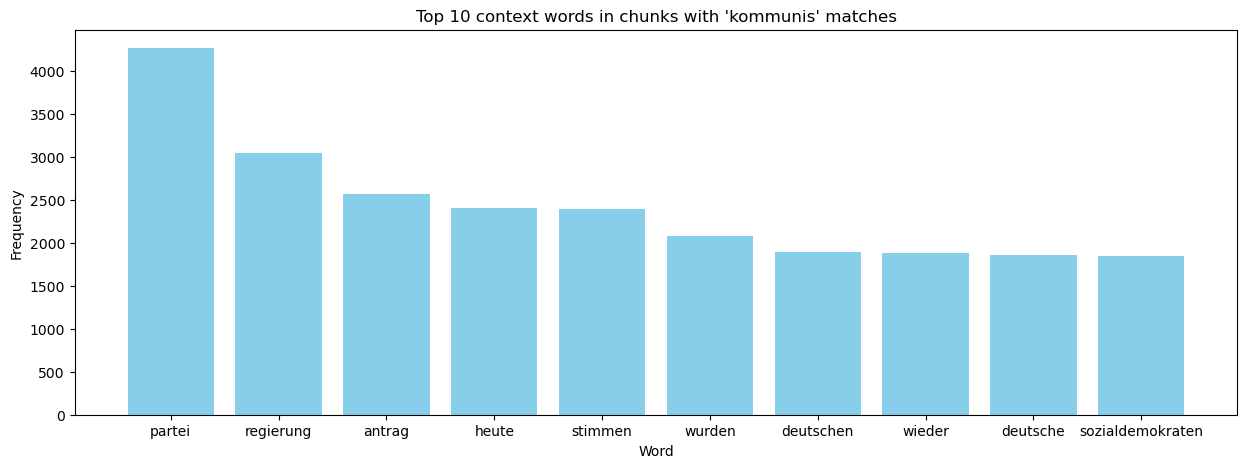

Plotting top words for term: sozial


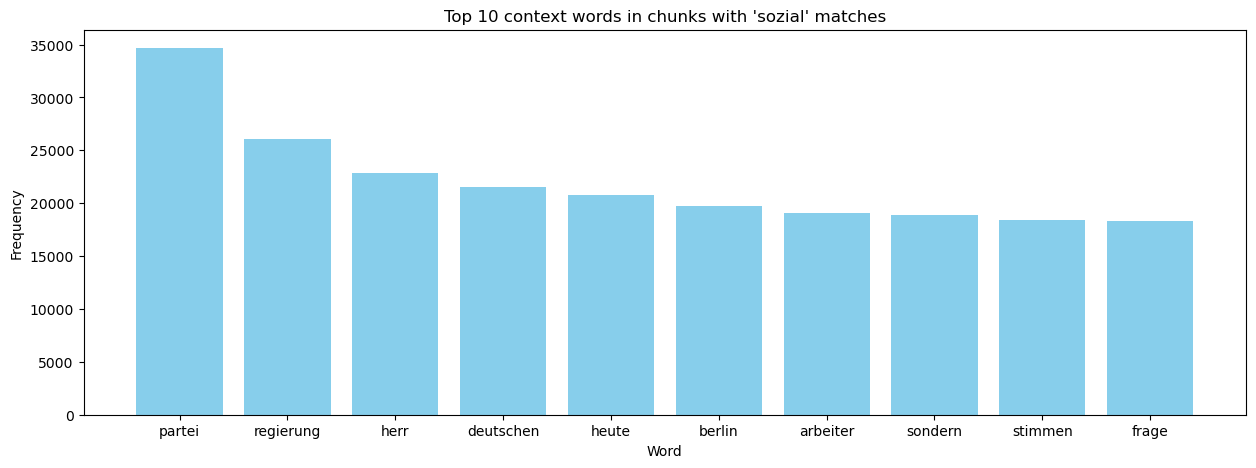

Plotting top words for term: revolut


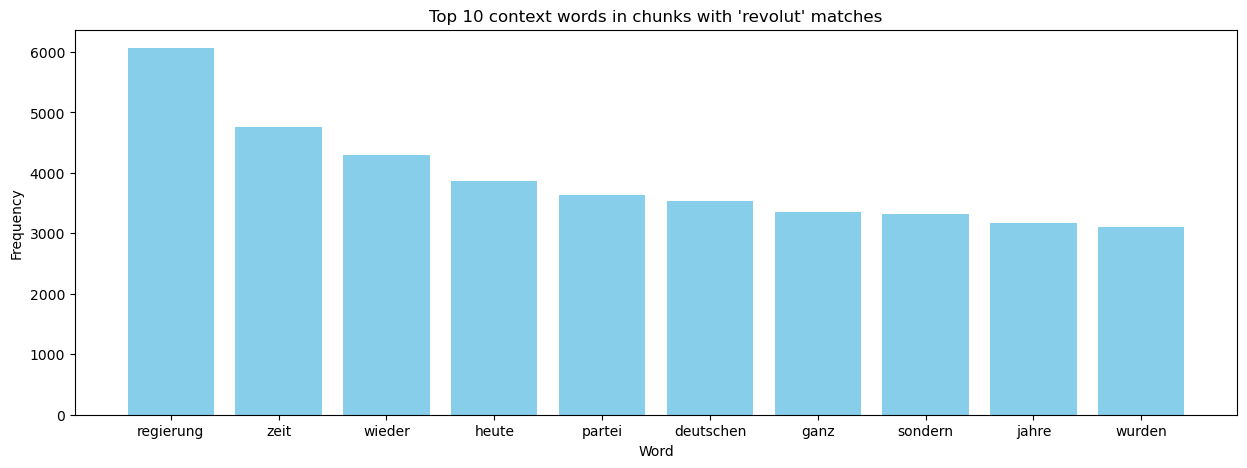

In [54]:
# Normalize all words in unique_words_sets
for term, words in unique_words_sets.items():
    unique_words_sets[term] = {w.strip().lower() for w in words if w.strip()}
for term, df in sub_dfs.items():
    print(f"Plotting top words for term: {term}")
    plot_top_words_in_chunks(df, col=term, chunk_col="chunk", top_n=10, min_len=4, exclude_words=unique_words_sets[term])

In [70]:
def plot_frequency_by_date_normalized(df, col, normalizer_df, date_col="pub_date", scale_exp=0, norm_col="word_count"):
    """
    Plot normalized frequency of matches per year.
    Normalized by yearly totals (words or issues).

    Parameters
    ----------
    df : DataFrame
        Sub-dataset for one search term.
    col : str
        Column containing lists of matches.
    normalizer_df : DataFrame
        DataFrame with yearly normalizers (from words_per_date or issues_per_date).
    date_col : str, default "pub_date"
        Column with publication dates (YYYY-MM-DD).
    scale_exp : int, default 0
        Multiply normalized values by 10**scale_exp (e.g. scale_exp=6 for per-million).
    norm_col : str, default "word_count"
        Column in normalizer_df to use for normalization ("word_count" or "issue_count").
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # Count matches per year
    yearly_matches = df.groupby(df[date_col].dt.year)[col].apply(
        lambda x: sum(len(lst) for lst in x)  # total number of matches in that year
    ).reset_index(name="matches")

    # Aggregate normalizer_df by year (if not already aggregated)
    normalizer_df = normalizer_df.copy()
    normalizer_df[date_col] = pd.to_datetime(normalizer_df[date_col], errors="coerce")
    yearly_norm = normalizer_df.groupby(normalizer_df[date_col].dt.year)[norm_col].sum().reset_index()

    # Merge matches with normalizer
    merged = pd.merge(yearly_matches, yearly_norm, left_on=date_col, right_on=date_col, how="inner")

    # Normalize
    merged["normalized"] = (merged["matches"] / merged[norm_col]) * (10 ** scale_exp)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(merged[date_col], merged["normalized"], marker="o")
    plt.title(f"Normalized frequency of '{col}' matches by year")
    plt.xlabel("Year")
    ylabel = f"Matches / {norm_col} × 10^{scale_exp}" if scale_exp else f"Matches / {norm_col}"
    plt.ylabel(ylabel)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    return merged

Plotting normalized by words frequency for term: anarch


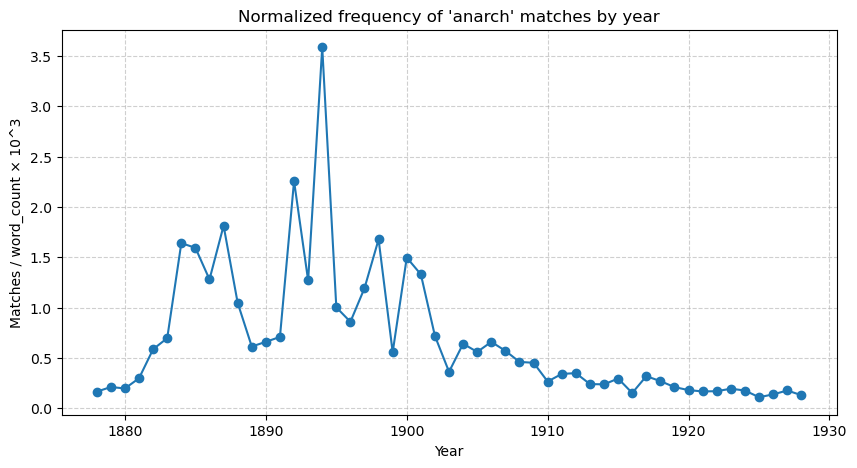

Plotting normalized by issues frequency for term: anarch


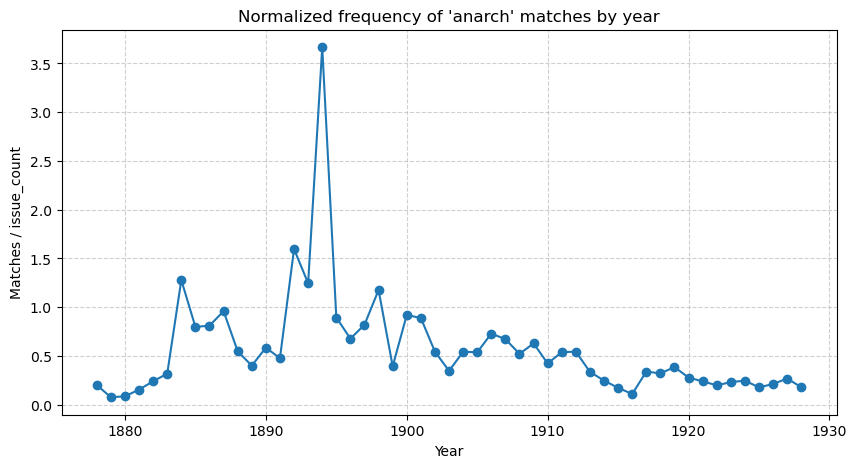

Plotting normalized by words frequency for term: terror


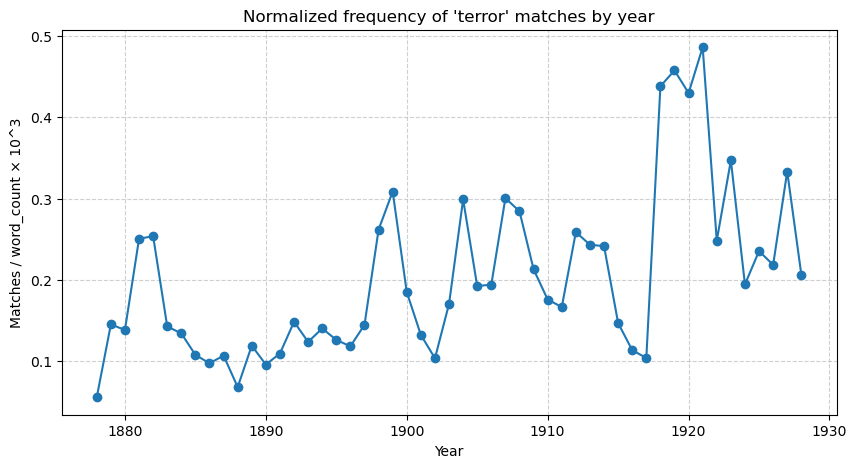

Plotting normalized by issues frequency for term: terror


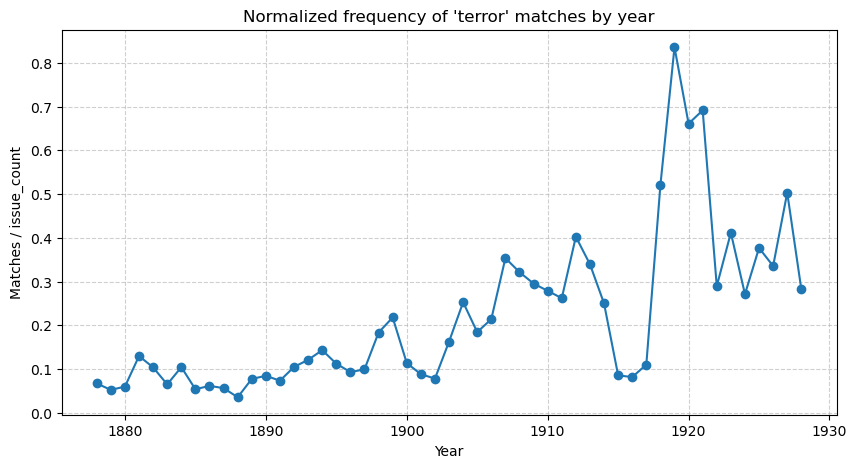

Plotting normalized by words frequency for term: kommunis


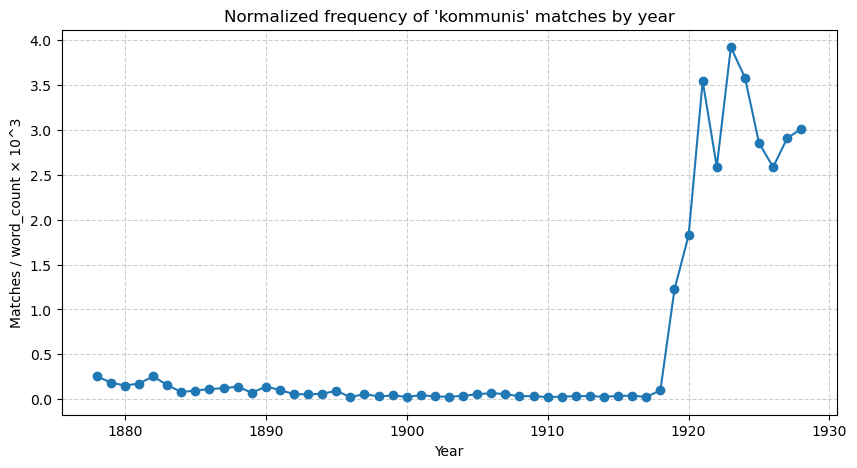

Plotting normalized by issues frequency for term: kommunis


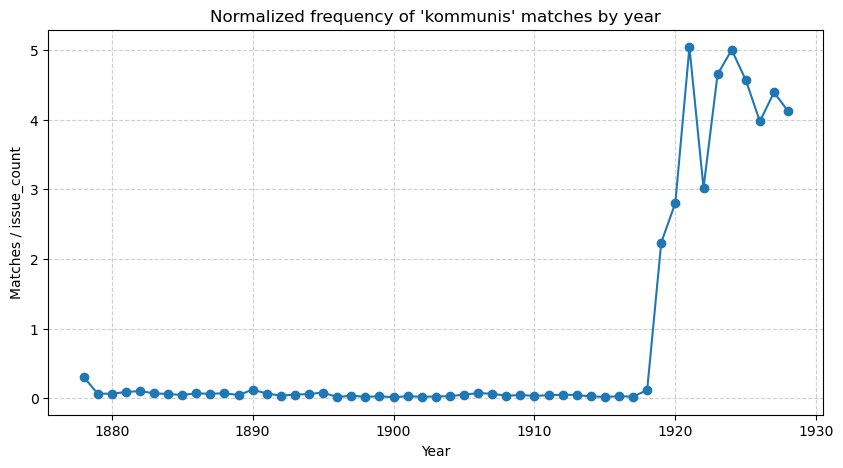

Plotting normalized by words frequency for term: sozial


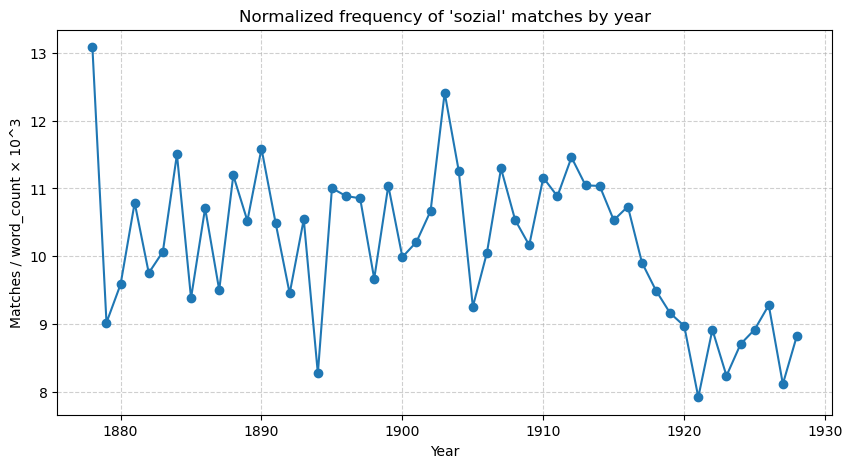

Plotting normalized by issues frequency for term: sozial


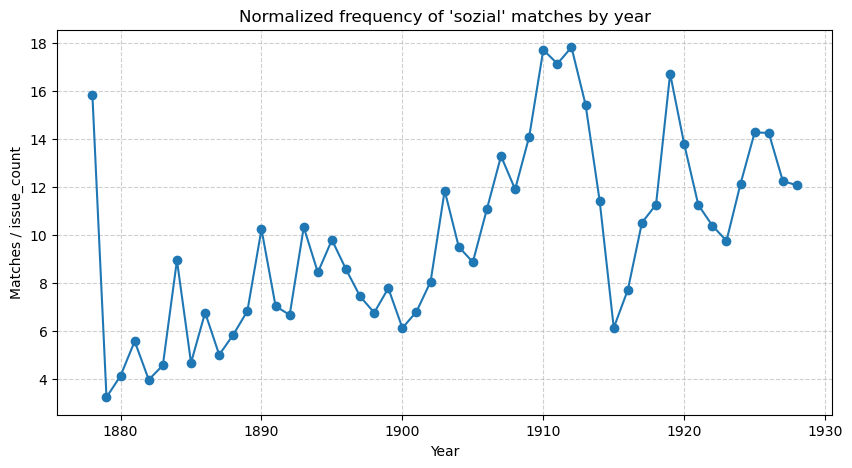

Plotting normalized by words frequency for term: revolut


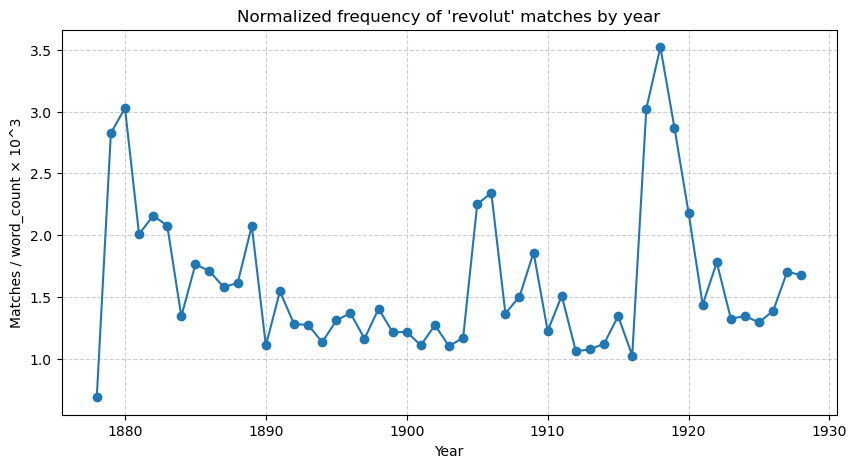

Plotting normalized by issues frequency for term: revolut


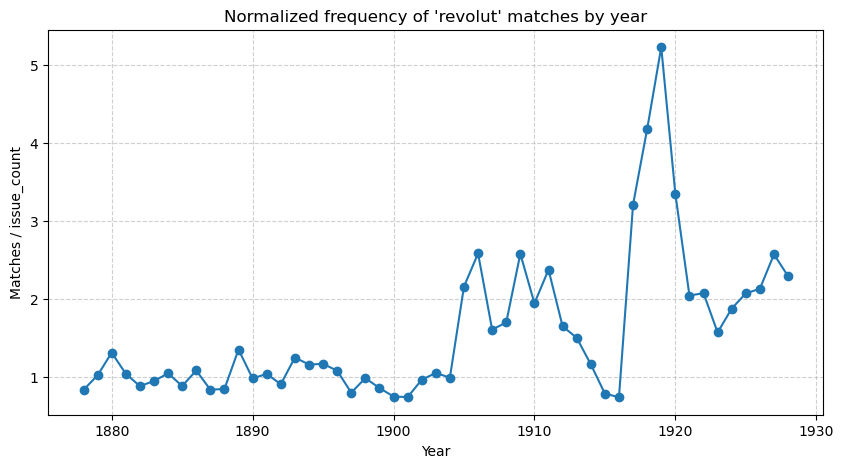

In [77]:
for term, df in sub_dfs.items():
    # Normalize by words
    print(f"Plotting normalized by words frequency for term: {term}")
    plot_frequency_by_date_normalized(sub_dfs[term], col=term, normalizer_df=word_stats, norm_col="word_count", scale_exp=3)

    # Normalize by issues
    print(f"Plotting normalized by issues frequency for term: {term}")
    plot_frequency_by_date_normalized(sub_dfs[term], col=term, normalizer_df=issue_stats, norm_col="issue_count", scale_exp=0)